# Making the mass-ratio priors
In this notebook, I will use the compiled companion and primary star data to estimate the mass-ratio prior for each of my detections.

The process will be:

1. Get the primary star mass
  - If it is in the David & Hillenbrand sample, use their mass
  - Otherwise, use the spectral type
  - Use Teff/logg from my ccfs and evolutionary tracks to get mass?
2. Get the companion mass. Use the corrected temperature and convert to mass
  - Use the Dartmouth evolutionary tracks to get a model grid mass
    - Use the David & Hillenbrand age, if available
    - Use the main-sequence age otherwise
  - Interpolate spectral type relationships

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py

import logging
import Priors

logger = logging.getLogger()
logger.setLevel(logging.INFO)
#logging.basicConfig(level=logging.DEBUG,
#                   filename='run.log',
#                    filemode='w')

%matplotlib inline

In [2]:
# Read in the companion temperature data
summary = pd.read_csv('Corrected_Companion_Data.csv', sep='|').drop_duplicates(subset=['Star'])

# Primary star mass estimates

(2.21804901648891, 5.0710701870361587)

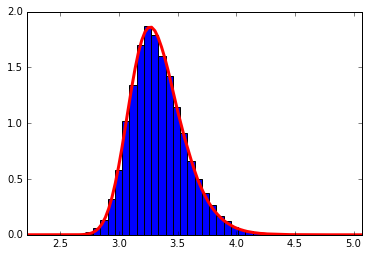

In [3]:
hipnum = '16611'
mass, prob = Priors.read_dh2015_posterior(hipnum=str(hipnum))
plt.plot(mass, prob, 'r-', lw=3)
mass_samples = Priors.get_primary_mass('HIP {}'.format(hipnum), spt='B2', size=1e4)
_ = plt.hist(mass_samples, bins=30, normed=True)
plt.xlim((mass_samples.min()-0.5, mass_samples.max()+0.5))

# Secondary Star Mass Estimates

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


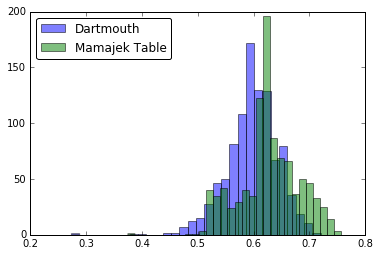

In [4]:
# Get mass samples from both the dartmouth and spectral type interpolator
dar = Priors.Feiden_Isochrone()
teff_samples = np.random.normal(loc=4000, scale=150, size=1e3)
iso_int = Priors.IsochroneInterpolator()
spt_int = Priors.SpectralTypeInterpolator()
dar_mass_samples = iso_int(teff_samples, 8.5)
spt_mass_samples = spt_int(teff_samples)

# Plot
plt.hist(dar_mass_samples, bins=30, alpha=0.5, label='Dartmouth')
plt.hist(spt_mass_samples, bins=30, alpha=0.5, label='Mamajek Table')
leg = plt.legend(loc='best', fancybox=True)


# Put everything together.
I will generate primary and secondary star mass estimates for every detection, and store them all in an HDF5 file. I will generate histograms of all of the samples along the way, so that I can check if anything looks weird.

In [5]:
summary.head()[['Star', 'configuration', 'SpT', 'vsini_sec', '[Fe/H]', 'Rank', 
                'Tmeas', 'Corrected_Temperature', 'T_lowerr', 'T_uperr', 'Mass', 'M1']]

,Star,configuration,SpT,vsini_sec,[Fe/H],Rank,Tmeas,Corrected_Temperature,T_lowerr,T_uperr,Mass,M1
0,HIP 2548,(5.70(5.84B9.5V + 7.99; 25.55y e=.80) + 9.6...,B9.5V,30,-0.5,1,5600.047668,5732.020192,111.956254,111.982127,0.999831,2.5
2,HIP 3478,B5V,B5V,5,-0.5,7,5799.802745,5524.152869,149.773113,149.773877,0.957460,4.6
3,HIP 5310,(A3V + ?; ?),A3V,30,0.0,3,3399.871770,3342.732718,154.357141,154.313632,0.352539,2.0
4,HR 545,B9V,B9.5IV,5,-0.5,1,4499.706320,4312.191145,87.255325,87.252411,0.728462,2.5
7,HR 604,(2.33K3IIb + 5.02(5.5(B7V + B9V; 2.67d) + 6.2A...,B8V+A0V,5,0.5,1,5000.070687,4735.568122,149.777704,149.773948,0.794541,3.4


In [6]:
iso_int = Priors.IsochroneInterpolator()
spt_int = Priors.SpectralTypeInterpolator()
logger.setLevel(logging.INFO)

N = 1e4
HDF5_OUTPUT = 'OrbitPrior.h5'
with h5py.File(HDF5_OUTPUT, 'w') as outfile:
    for idx, row in summary.iterrows():
        # Get primary mass samples
        hipnum = row['Star'].split('HIP')[-1].strip()
        primary_mass = Priors.get_primary_mass(star=row['Star'], spt=row['SpT'], size=N, mass_err=0.1)

        # Get system age estimate
        age = Priors.get_ages(starname=row['Star'], spt=row['SpT'], size=N)

        # Get companion mass estimates
        teff_samples = np.random.normal(loc=row['Corrected_Temperature'],
                                        scale=max(row['T_lowerr'], row['T_uperr']),
                                        size=len(primary_mass))
        
        companion_isomass = iso_int(teff_samples, np.log10(age)+6)
        companion_sptmass = spt_int(teff_samples)

        # Save the data in the HDF5 file
        star_grp = outfile.create_group(row['Star'])
        _ = star_grp.create_dataset('primary', data=primary_mass)
        _ = star_grp.create_dataset('companion_isochrone', data=companion_isomass)
        _ = star_grp.create_dataset('companion_spectral_type', data=companion_sptmass)
        _ = star_grp.create_dataset('system_age', data=age)
        
        # Save the star data as attributes of the group.
        for col in ['SpT', 'configuration', 'vsini_sec', '[Fe/H]', 'Rank',
                    'Tmeas', 'Tmeas_err', 'Corrected_Temperature', 'T_lowerr', 'T_uperr']:
            star_grp.attrs[col] = row[col]
        
        outfile.flush()

INFO:root:Getting stellar data for HIP 37450
INFO:root:Main Sequence age for HIP 37450 is 50 Myr
INFO:root:Getting stellar data for HIP 46283


SELECT * FROM star WHERE name IN ('HIP 37450')
SELECT * FROM star WHERE name IN ('HIP 46283')

INFO:root:Main Sequence age for HIP 46283 is 63 Myr
INFO:root:Getting stellar data for HIP 96840



SELECT * FROM star WHERE name IN ('HIP 96840')

INFO:root:Main Sequence age for HIP 96840 is 50 Myr


In [7]:
# Make a raw mass-ratio distribution
def mode(a, bins=30):
    vals, bins = np.histogram(a[~np.isnan(a)], bins=bins)
    mode = bins[np.argmax(vals)]
    return mode

spt_q = []
iso_q = []
with h5py.File(HDF5_OUTPUT, 'r') as f:
    for starname, star_grp in f.iteritems():
        primary_mass = star_grp['primary'].value
        companion_isomass = star_grp['companion_isochrone']
        companion_sptmass = star_grp['companion_spectral_type']
        
        M1 = mode(primary_mass)
        M2_iso = mode(companion_isomass)
        M2_spt = mode(companion_sptmass)
        spt_q.append(min(M1/M2_spt, M2_spt/M1))
        iso_q.append(min(M1/M2_iso, M2_iso/M1))

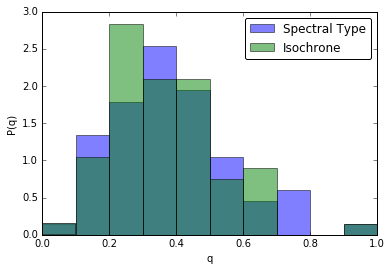

In [8]:
bins = np.arange(0, 1.05, 0.1)
plt.hist(spt_q, bins=bins, alpha=0.5, label='Spectral Type', normed=True)
plt.hist(iso_q, bins=bins, alpha=0.5, label='Isochrone', normed=True)
leg = plt.legend(loc='best', fancybox=True)
plt.xlabel('q')
plt.ylabel('P(q)')